## Problem

Detection of probable backorders(returned orders) on e-commerce products' transactions using Machine Learning

## About

Often we see that some products that are ordered from e-commerce websites get returned back to the vendor dude to various reasons like damaged goods, customer dissatisfaction etc. This creates a lot of disruption in the logistics and supply-chain management for the e-commerce service provider . If a product gets returned back, along with the obvious transportation charges, it involves a lot of planning for storing that product in the warehouses or accounting for it in the inventory etc. Hence it will prove to be very beneficial to an e-commerce service provider if such backorders could be anticipated by them and they could account for it's disruptions beforehand to maintain the smoothness of their operations. 

In [19]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data

Part backorders is a common supply chain problem. Working to identify parts at risk of backorder before the event occurs so the business has time to react.

Training data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. 

Columns are defined as follows:
sku - Random ID for the product
national_inv - Current inventory level for the part
lead_time - Transit time for product (if available)
in_transit_qty - Amount of product in transit from source
forecast_3_month - Forecast sales for the next 3 months
forecast_6_month - Forecast sales for the next 6 months
forecast_9_month - Forecast sales for the next 9 months
sales_1_month - Sales quantity for the prior 1 month time period
sales_3_month - Sales quantity for the prior 3 month time period
sales_6_month - Sales quantity for the prior 6 month time period
sales_9_month - Sales quantity for the prior 9 month time period
min_bank - Minimum recommend amount to stock
potential_issue - Source issue for part identified
pieces_past_due - Parts overdue from source
perf_6_month_avg - Source performance for prior 6 month period
perf_12_month_avg - Source performance for prior 12 month period
local_bo_qty - Amount of stock orders overdue
deck_risk - Part risk flag
oe_constraint - Part risk flag
ppap_risk - Part risk flag
stop_auto_buy - Part risk flag
rev_stop - Part risk flag
went_on_backorder - Product actually went on backorder. This is the target value.


The data has 1687861 rows and 23 features with a size of around 300 mb


In [12]:
df = pd.read_csv('../Data/Train.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
sku                  1687861 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null object
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null object
oe_constraint        1687860 non-null object
ppap_risk        

In [13]:
df.isnull().sum()

sku                       0
national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

## Data Munging

In this section, we identify the impurities in the data and clean them to make it suitable for further processing.
The techniques applied in this is rectifying missing data and converting the string fields to numeric form with binarization. Also we are normalizing the data to give us better insights as to what steps to take for a better modelling.

Explaining some of the strategies used in the preprocessing:

1.    Slice the dataset in half, cutting off items with no forecast or sales in the past 3 months. This strategy allows us to reduce 50% the original dataset, loosing only 300 items
2.    Binaries were converted from strings ('Yes' and 'No') to 1 and 0.
3.    The attributes related to quantities were normalized (std dev equal to 1) per row. Therefore, parts with different order of magnitudes are approximated. For example: 1 unit of a expensive machine may be different from 1 unit of a screw, but if we standard deviate all the quantities we have, we can get a better proportion of equivalence between those items.
4.    Missing values for lead_time and perf_month_avg were replaced using series median and mean.


In [14]:

def process(df):
    # Imput missing lines and drop line with problem
    from sklearn.preprocessing import Imputer
    df['lead_time'] = Imputer(strategy='median').fit_transform(
                                    df['lead_time'].values.reshape(-1, 1))
    df = df.dropna()
    for col in ['perf_6_month_avg', 'perf_12_month_avg']:
        df[col] = Imputer(missing_values=-99).fit_transform(df[col].values.reshape(-1, 1))
    # Convert to binaries
    for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
               'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
        df[col] = (df[col] == 'Yes').astype(int)
    # Normalization    
    from sklearn.preprocessing import normalize
    qty_related = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 'sales_3_month', 
                   'sales_6_month', 'sales_9_month',]
    df[qty_related] = normalize(df[qty_related], axis=1)
    # Obsolete parts - optional
    #df = df.loc[(df["forecast_3_month"]>0)|(df["sales_9_month"]>0)]
    return df

In [15]:
df = process(df)
print df

             sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0        1026827      0.000000        8.0        0.000000          0.000000   
1        1043384      1.000000        9.0        0.000000          0.000000   
2        1043696      1.000000        8.0        0.000000          0.000000   
3        1043852      0.989949        8.0        0.000000          0.000000   
4        1044048      0.872872        8.0        0.000000          0.000000   
5        1044198      1.000000        8.0        0.000000          0.000000   
6        1044643      0.999993        8.0        0.000000          0.000000   
7        1045098      1.000000        2.0        0.000000          0.000000   
8        1045815      0.592005        8.0        0.000000          0.063429   
9        1045867      1.000000        8.0        0.000000          0.000000   
10       1045918      0.000000        2.0        0.000000          0.000000   
11       1047146      1.000000        8.0        0.0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
sku                  1687860 non-null object
national_inv         1687860 non-null float64
lead_time            1687860 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null int64
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null int64
oe_constraint        1687860 non-null int64
ppap_risk           

In [16]:
cols=range(1,23)

## Data Analysis

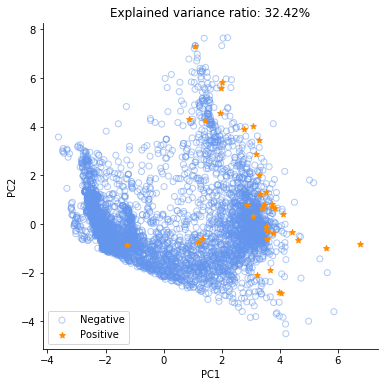

In [17]:
def plot_2d(X, y, title=''):
    from sklearn.preprocessing import StandardScaler
    X_std = StandardScaler().fit_transform(X)

    from sklearn.decomposition import PCA
    dec = PCA(n_components=2)
    X_reduced = dec.fit_transform(X_std)
    
    f, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X_reduced[y==0,0], X_reduced[y==0,1], alpha=0.5, 
               facecolors='none', edgecolors='cornflowerblue', label="Negative")
    ax.scatter(X_reduced[y==1,0], X_reduced[y==1,1], c='darkorange', marker='*', 
               label='Positive')
    plt.title("Explained variance ratio: %.2f%%" % (100*dec.explained_variance_ratio_.sum()))
    ax.legend(loc='lower left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    plt.show()
    
sample = df.sample(5000, random_state=36)

X_sample = sample.drop('went_on_backorder',axis=1).values
y_sample = sample['went_on_backorder'].values

plot_2d(X_sample, y_sample)


In the above figure we have found out the explained variance by plotting a sample of the dataset.
To provide a basic understanding about the problem, we used PCA to reduce the dataset to 2 components, and plot according to the class - black stars represent the minority or positive class (items which went on backorder), whilst empty circles represent majority or negative class (other items).

In [20]:
X = df.drop('went_on_backorder', axis=1).values
y = df['went_on_backorder'].values
print('Imbalanced ratio in training set: 1:%i' % (Counter(y)[0]/Counter(y)[1]))

Imbalanced ratio in training set: 1:148


As you can see, the imbalance is quite large for this data with the minority class being almost 0.6% of the data

## Data Modeling

In this section we will be treating the Imbalance and fit different models to our data
We adopted here 3 estimators. Note that we do not use cross-validation or parameter tuning yet.

1.    DecisionTree (CART): This is our base estimator of all methods. Decision trees present great results in imbalanced domains, since it leafs are generated using 'gini' or 'entropy', not 'accuracy' as general learning algorithms.
2.    RandomUnderSampling (RUS): One of the most common sampling techniques. Rexamples the dataset by eliminating random instances of majority class.
3.    RandomForest (FOREST): Bagging-based ensemble.
4. GradientBoosting (GBOOST): Boosting-based ensemble.
5. UnderBagging - A different model, not currently implemented in sklearn. It works as a bagging of emphasized textundersampled sets. We used the sklearn.ensemble.BaggingClassifier and imblearn.ensemble.RandomUnderSampler to reproduce the UnderBagging model.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

from sklearn import tree, ensemble
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

cart = tree.DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5)
rus = make_pipeline(RandomUnderSampler(),tree.DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=5))
forest = ensemble.RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=5)
gboost = ensemble.GradientBoostingClassifier(max_depth=15, min_samples_leaf=5)

cart.fit(X_train, y_train)
rus.fit(X_train, y_train)
forest.fit(X_train, y_train)

n_splits = 10

In [23]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
ub = BaggingClassifier(warm_start=True, n_estimators=0)

for split in range(n_splits):
    X_res, y_res = RandomUnderSampler(random_state=split).fit_sample(X_train,y_train) 
    ub.n_estimators += 1
    ub.fit(X_res, y_res)

## Visual Analysis and Evaluation

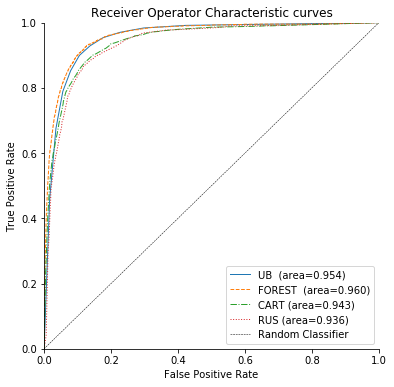

In [24]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_proba[:,1])))

f, ax = plt.subplots(figsize=(6,6))

roc_auc_plot(y_test,ub.predict_proba(X_test),label='UB ',l='-')
roc_auc_plot(y_test,forest.predict_proba(X_test),label='FOREST ',l='--')
roc_auc_plot(y_test,cart.predict_proba(X_test),label='CART', l='-.')
roc_auc_plot(y_test,rus.predict_proba(X_test),label='RUS',l=':')

ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        label='Random Classifier')    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()

The above is the AUC-ROC plot for the different models fitted to the data

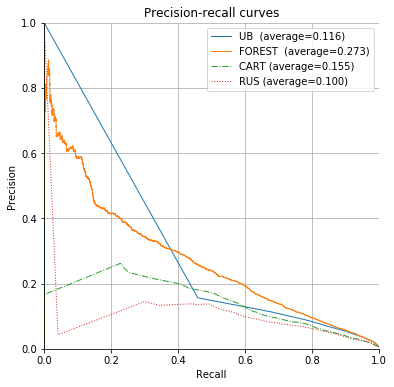

In [25]:
def precision_recall_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test,
                                                  y_proba[:,1])
    average_precision = average_precision_score(y_test, y_proba[:,1],
                                                     average="micro")
    ax.plot(recall, precision, label='%s (average=%.3f)'%(label,average_precision),
            linestyle=l, linewidth=lw)

f, ax = plt.subplots(figsize=(6,6))
precision_recall_plot(y_test,ub.predict_proba(X_test),label='UB ',l='-')
precision_recall_plot(y_test,forest.predict_proba(X_test),label='FOREST ',l='-')
precision_recall_plot(y_test,cart.predict_proba(X_test),label='CART',l='-.')
precision_recall_plot(y_test,rus.predict_proba(X_test),label='RUS',l=':')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc="upper right")
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Precision-recall curves')
sns.despine()


The above is the Precision-Recall plot for the same models

## Results

Ensembles and sampling can easily be combined to perform best results. There are several other models can be applied, i.e. RUSBoost, SMOTEBoost, OverBagging, SMOTEBagging.

The best working model here is UnderBagging, because in the given dataset, which presents almost 1.8 millions of majority examples case, undersampling greatly increases the computational cost of model fitting.

The CART model, as a weak and soft classifier can be a useful base_classifier. Although, others classifiers can be used:  SVM, KNN, RandomForests, LDA, among others.

